# NLP Stock Market Prediction (Apple)
Within this notebook we perfom sentiment analysis on tweets that have been manually labelled with their corresponding stock ticker. Subsequent to the sentiment analysis using VADER, Random Forest is used to predict the closing prices of Apple Stock over 2 months. 

This pipeline can be used for any stock ticker.

In [1]:
import yfinance as yf
import datetime
import pandas as pd
import unicodedata
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# Load the yfinance data of the top 25 most watched stock tickers on Yahoo FInance from 30-09-2021 to 30-09-2022
file_path = "/Users/timseidel/Documents/DHBW_Studium/NLP/stock_tweets/stock_yfinance_data.csv"
stock_df = pd.read_csv(file_path)
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [3]:
# Load the tweets of top 25 most watched stock tickers on Yahoo FInance from 30-09-2021 to 30-09-2022
file_path = "/Users/timseidel/Documents/DHBW_Studium/NLP/stock_tweets/stock_tweets.csv"
twitter_df = pd.read_csv(file_path)

In [4]:
# Create sub-dataframes with only those tweets and yfinance data corresponding to Apple
apple_stocks = "AAPL"
apple_df = twitter_df[twitter_df['Stock Name'] == apple_stocks]
apple_stock_df = stock_df[stock_df['Stock Name'] == apple_stocks]

### Preprocess the Tweets
This means changing all tweets to lower case, removing hashtags, special characters, dealing with contractions, etc

In [5]:
apple_preprocessed_df = apple_df.copy()

# Preprocess the text (e.g., lowercase, remove special characters, etc.) and normalize it
def preprocessed_normalized_text(tweet):
    tweet = tweet.lower() # Lower Case
    tweet = re.sub(r'#\w+', '', tweet) # Removes Hashtags
    tweet = re.sub(r'@(\w+)','', tweet) # Removes User mentions
    #tweet = re.sub(r'[^\w\s]', '', text) # Removes Punctuation
    tweet = re.sub(r'[^a-zA-Z0-9%\s]', '', tweet) # Removes special characters
    tweet = re.sub(r'http[s]?://\S+|www\.\S+', '', tweet) # Remove URLs

    # Lemmatization and Tokenization

    
    # Normalize the text using 'NFKD' normalization form
    normalized_text = unicodedata.normalize('NFKD', tweet)
    return normalized_text

# Call the preprocessed_normalized_text(tweet) function
apple_preprocessed_df['Normalized_Tweet'] = apple_preprocessed_df['Tweet'].apply(preprocessed_normalized_text)

In [6]:
# Replace some if not all of the contractions
contractions_dict = {
    "%": " percent", "ain't": "am not / are not", "aren't": "are not / am not", "can't": "cannot",
    "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not",
    "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not",
    "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not",
    "he'd": "he had / he would", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have",
    "he's": "he is / he has", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
    "how's": "how is / how has", "i'd": "i had / i would", "i'd've": "i would have", "i'll": "i will",
    "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it had / it would",
    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is / it has",
    "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not",
    "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
    "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not",
    "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
    "she'd": "she had / she would", "she'd've": "she would have", "she'll": "she will", 
    "she'll've": "she will have", "she's": "she is / she has", "should've": "should have",
    "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so is / so has",
    "that'd": "that would / that had", "that'd've": "that would have", "that's": "that is / that has",
    "there'd": "there had / there would", "there'd've": "there would have", "there's": "there is / there has",
    "they'd": "they had / they would", "they'd've": "they would have", "they'll": "they will",
    "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
    "wasn't": "was not", "we'd": "we had / we would", "we'd've": "we would have", "we'll": "we will",
    "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
    "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is / what has",
    "what've": "what have", "when's": "when is / when has", "when've": "when have", "where'd": "where did",
    "where's": "where is / where has", "where've": "where have", "who'll": "who will",
    "who'll've": "who will have", "who's": "who is / who has", "who've": "who have", "why's": "why is / why has",
    "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
    "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are",
    "y'all've": "you all have", "you'd": "you had / you would", "you'd've": "you would have"
}

def replace_contractions(tweet, contractions_dict):
    for contraction, expansion in contractions_dict.items():
        tweet = tweet.replace(contraction, expansion)
    return tweet

apple_preprocessed_df['Normalized_Preprocessed_Tweet'] = apple_preprocessed_df['Normalized_Tweet'].apply(lambda x: replace_contractions(x, contractions_dict))
apple_preprocessed_df.head()

,Date,Tweet,Stock Name,Company Name,Normalized_Tweet,Normalized_Preprocessed_Tweet
55958,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AAPL,Apple Inc.,nio just because im down money doesnt mean thi...,nio just because im down money doesnt mean thi...
55959,2022-09-29 20:37:01+00:00,After trading for 9+ years \n\nThis is how to ...,AAPL,Apple Inc.,after trading for 9 years \n\nthis is how to f...,after trading for 9 years \n\nthis is how to f...
55960,2022-09-29 20:19:43+00:00,Not something you see very often. \n-2 ATR mo...,AAPL,Apple Inc.,not something you see very often \n2 atr move...,not something you see very often \n2 atr move...
55961,2022-09-29 20:13:48+00:00,$AAPL was down almost 5% today. Rare to see it...,AAPL,Apple Inc.,aapl was down almost 5% today rare to see it s...,aapl was down almost 5 percent today rare to s...
55962,2022-09-29 19:50:00+00:00,$AAPL APPLE JUST FIRED ITS HEAD OF PROCUREMENT...,AAPL,Apple Inc.,aapl apple just fired its head of procurement ...,aapl apple just fired its head of procurement ...


### Perform Sentiment Analysis
We shall utilize the Sentiment Intensity Analyzer from VADER

In [7]:
# Create a new data frame for sentiment analysis
apple_sentiment = apple_preprocessed_df.copy()

# Initialize the Analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment scores for each tweet
def get_sentiment_scores(tweet):
    sentiment = analyzer.polarity_scores(tweet)
    return sentiment

# Apply sentiment analysis to the dataset
apple_sentiment['Sentiment_Scores'] = apple_sentiment['Normalized_Preprocessed_Tweet'].apply(get_sentiment_scores)

# Extract and create columns for compound, positive, negative, and neutral scores
apple_sentiment['sentiment_score'] = apple_sentiment['Sentiment_Scores'].apply(lambda x: x['compound'])
apple_sentiment['Negative'] = apple_sentiment['Sentiment_Scores'].apply(lambda x: x['neg'])
apple_sentiment['Neutral'] = apple_sentiment['Sentiment_Scores'].apply(lambda x: x['neu'])
apple_sentiment['Positive'] = apple_sentiment['Sentiment_Scores'].apply(lambda x: x['pos'])

apple_sentiment.head()

,Date,Tweet,Stock Name,Company Name,Normalized_Tweet,Normalized_Preprocessed_Tweet,Sentiment_Scores,sentiment_score,Negative,Neutral,Positive
55958,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AAPL,Apple Inc.,nio just because im down money doesnt mean thi...,nio just because im down money doesnt mean thi...,"{'neg': 0.158, 'neu': 0.684, 'pos': 0.158, 'co...",0.2500,0.158,0.684,0.158
55959,2022-09-29 20:37:01+00:00,After trading for 9+ years \n\nThis is how to ...,AAPL,Apple Inc.,after trading for 9 years \n\nthis is how to f...,after trading for 9 years \n\nthis is how to f...,"{'neg': 0.0, 'neu': 0.912, 'pos': 0.088, 'comp...",0.3612,0.000,0.912,0.088
55960,2022-09-29 20:19:43+00:00,Not something you see very often. \n-2 ATR mo...,AAPL,Apple Inc.,not something you see very often \n2 atr move...,not something you see very often \n2 atr move...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,1.000,0.000
55961,2022-09-29 20:13:48+00:00,$AAPL was down almost 5% today. Rare to see it...,AAPL,Apple Inc.,aapl was down almost 5% today rare to see it s...,aapl was down almost 5 percent today rare to s...,"{'neg': 0.182, 'neu': 0.699, 'pos': 0.119, 'co...",-0.2500,0.182,0.699,0.119
55962,2022-09-29 19:50:00+00:00,$AAPL APPLE JUST FIRED ITS HEAD OF PROCUREMENT...,AAPL,Apple Inc.,aapl apple just fired its head of procurement ...,aapl apple just fired its head of procurement ...,"{'neg': 0.122, 'neu': 0.878, 'pos': 0.0, 'comp...",-0.5574,0.122,0.878,0.000


In [8]:
# Create a new data frame with Date, Tweet, and Sentiment Score
df_for_prediction_apple = apple_sentiment[['Date', 'Normalized_Preprocessed_Tweet', 'sentiment_score']]
df_for_prediction_apple = df_for_prediction_apple.sort_values(by='Date')
df_for_prediction_apple['Date'] = pd.to_datetime(df_for_prediction_apple['Date']).dt.date
df_for_prediction_apple

,Date,Normalized_Preprocessed_Tweet,sentiment_score
61013,2021-09-30,i bought my first aapl stock in 2010 \n\nsince...,0.3182
61012,2021-09-30,the media is really pushing hard for their big...,0.1585
61011,2021-09-30,in 2020 tim cook ceo of aapl earned 265000000 ...,0.0000
61010,2021-09-30,this thread is just a broad overview of the ba...,0.4767
61009,2021-09-30,all about this trendline now on aapl continuin...,-0.4019
...,...,...,...
55962,2022-09-29,aapl apple just fired its head of procurement ...,-0.5574
55961,2022-09-29,aapl was down almost 5 percent today rare to s...,-0.2500
55960,2022-09-29,not something you see very often \n2 atr move...,0.0000
55959,2022-09-29,after trading for 9 years \n\nthis is how to f...,0.3612


In [ ]:
# Given the yfinance data for Apple, calculate the price difference between the closing and opening price
# and add it to the initial dataframe
apple_stock_df['Date'] = pd.to_datetime(apple_stock_df['Date']).dt.date
apple_stock_df['Price_Difference'] = apple_stock_df['Close'] - apple_stock_df['Open']

In [10]:
# Merge the sentiment data with the Price Difference using the 'Date' column
combined_data = pd.merge(df_for_prediction_apple, apple_stock_df[['Date', 'Price_Difference']], on='Date', how='left')
# There exist NaN values that need to be dropped (may have resulting from weekends)
combined_data = combined_data.dropna() 
combined_data

,Date,Normalized_Preprocessed_Tweet,sentiment_score,Price_Difference
0,2021-09-30,i bought my first aapl stock in 2010 \n\nsince...,0.3182,-2.160004
1,2021-09-30,the media is really pushing hard for their big...,0.1585,-2.160004
2,2021-09-30,in 2020 tim cook ceo of aapl earned 265000000 ...,0.0000,-2.160004
3,2021-09-30,this thread is just a broad overview of the ba...,0.4767,-2.160004
4,2021-09-30,all about this trendline now on aapl continuin...,-0.4019,-2.160004
...,...,...,...,...
5051,2022-09-29,aapl apple just fired its head of procurement ...,-0.5574,-3.620010
5052,2022-09-29,aapl was down almost 5 percent today rare to s...,-0.2500,-3.620010
5053,2022-09-29,not something you see very often \n2 atr move...,0.0000,-3.620010
5054,2022-09-29,after trading for 9 years \n\nthis is how to f...,0.3612,-3.620010


### ML Price Prediction
We shall utilize various algorithms to predict the price difference and as such the closing price. There exist several tweets per day but just one opening and closing price. Therefore, we decided it would be best to add the price difference to each tweet, resulting in the data frame you can see above. If we were to have taken the average sentiment value per day instead of adding the price difference to each tweet, we would have been left with too few training data.

In [11]:
# Define feature and target variable
X = combined_data[['sentiment_score']]
y = combined_data['Price_Difference']

# Reshape X to be a 2D array
X = X.values.reshape(-1, 1)

# Split the data into training and testing sets
# The first 80% of the data is used to train and the rest is used for testing
split_index = int(0.8 * len(X))  # Calculate the split index
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Create and initilize various ML Models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 7.0996249759204755
R-squared: -0.1495128407135775


In [12]:
# Given the y_pred add the array to the combined_data dataframe but make sure it's just the test data
last_20_percent_data = combined_data[split_index:]
last_20_percent_data['Predicted_Price_Difference'] = y_pred
last_20_percent_data

/var/folders/2v/08tsvr012r9cy229qthszhr40000gn/T/ipykernel_66374/3734233585.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_20_percent_data['Predicted_Price_Difference'] = y_pred


,Date,Normalized_Preprocessed_Tweet,sentiment_score,Price_Difference,Predicted_Price_Difference
4037,2022-07-29,hey bulls\n\nmedian real revenue growth for fa...,-0.2732,1.269989,-0.233746
4038,2022-07-29,me amp my bear bias all week\nspy qqq tsla aap...,-0.1027,1.269989,-1.222152
4039,2022-07-29,aapl finishes the day higher by 332 percent le...,0.0000,1.269989,0.284754
4040,2022-07-29,apple aapl and amazon amzn added a combined 20...,0.1779,1.269989,0.855597
4041,2022-07-29,aapl daily spinning top after huge gap up into...,0.4767,1.269989,0.246951
...,...,...,...,...,...
5051,2022-09-29,aapl apple just fired its head of procurement ...,-0.5574,-3.620010,-1.045843
5052,2022-09-29,aapl was down almost 5 percent today rare to s...,-0.2500,-3.620010,-0.666158
5053,2022-09-29,not something you see very often \n2 atr move...,0.0000,-3.620010,0.284754
5054,2022-09-29,after trading for 9 years \n\nthis is how to f...,0.3612,-3.620010,0.688235


### Visualization of the Predicted Closing Prices
The values obtained from the ML model above are predicted price differences per day. There exist several tweets per day, therefore we determined it would be most useful to compute the average predicted price difference per day. The average predicted price difference per day is then added to the opening price of that day in order to compute the respective closing price. The predicted and actual closing prices are visualized at the end.

In [13]:
# Compute the average predicted price diff
average_predicted_price_diff = last_20_percent_data.groupby('Date')['Predicted_Price_Difference'].mean().reset_index()

# Rename the column for clarity
average_predicted_price_diff = average_predicted_price_diff.rename(columns={'Predicted_Price_Difference': 'Average_Predicted_Price_Difference'})

# Display the resulting DataFrame
average_predicted_price_diff

,Date,Average_Predicted_Price_Difference
0,2022-07-29,0.044124
1,2022-08-01,0.436805
2,2022-08-02,0.210922
3,2022-08-03,0.674592
4,2022-08-04,0.626262
5,2022-08-05,1.146882
6,2022-08-08,0.544004
7,2022-08-09,0.171931
8,2022-08-10,0.847805
9,2022-08-11,0.313816


In [14]:
# Ensure the "Date" column is of datetime type
apple_stock_df['Date'] = pd.to_datetime(apple_stock_df['Date'])

# Filter rows for dates starting from 2022-07-29
filtered_df = apple_stock_df[apple_stock_df['Date'] >= '2022-07-29']
# Ensure the 'Date' column is of datetime type
filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])

# Ensure the 'Date' column is of datetime type in the average_predicted_price_diff DataFrame
average_predicted_price_diff['Date'] = pd.to_datetime(average_predicted_price_diff['Date'])

# Merge the two DataFrames based on the 'Date' column
merged_df = filtered_df.merge(average_predicted_price_diff, on='Date', how='left')

# Calculate the 'Predicted closing' by adding 'Open' and 'Average_Predicted_Price_Difference'
merged_df['Predicted closing'] = merged_df['Open'] + merged_df['Average_Predicted_Price_Difference']

# Display the resulting DataFrame
columns_to_drop = ['High', 'Low', 'Adj Close', 'Volume', 'Stock Name']
merged_df = merged_df.drop(columns=columns_to_drop)
merged_df

/var/folders/2v/08tsvr012r9cy229qthszhr40000gn/T/ipykernel_66374/938563839.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_stock_df['Date'] = pd.to_datetime(apple_stock_df['Date'])
/var/folders/2v/08tsvr012r9cy229qthszhr40000gn/T/ipykernel_66374/938563839.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])


,Date,Open,Close,Price_Difference,Average_Predicted_Price_Difference,Predicted closing
0,2022-07-29,161.240005,162.509995,1.269989,0.044124,161.284129
1,2022-08-01,161.009995,161.509995,0.500000,0.436805,161.446800
2,2022-08-02,160.100006,160.009995,-0.090012,0.210922,160.310928
3,2022-08-03,160.839996,166.130005,5.290009,0.674592,161.514588
4,2022-08-04,166.009995,165.809998,-0.199997,0.626262,166.636257
5,2022-08-05,163.210007,165.350006,2.139999,1.146882,164.356889
6,2022-08-08,166.369995,164.869995,-1.500000,0.544004,166.913999
7,2022-08-09,164.020004,164.919998,0.899994,0.171931,164.191935
8,2022-08-10,167.679993,169.240005,1.560013,0.847805,168.527798
9,2022-08-11,170.059998,168.490005,-1.569992,0.313816,170.373813


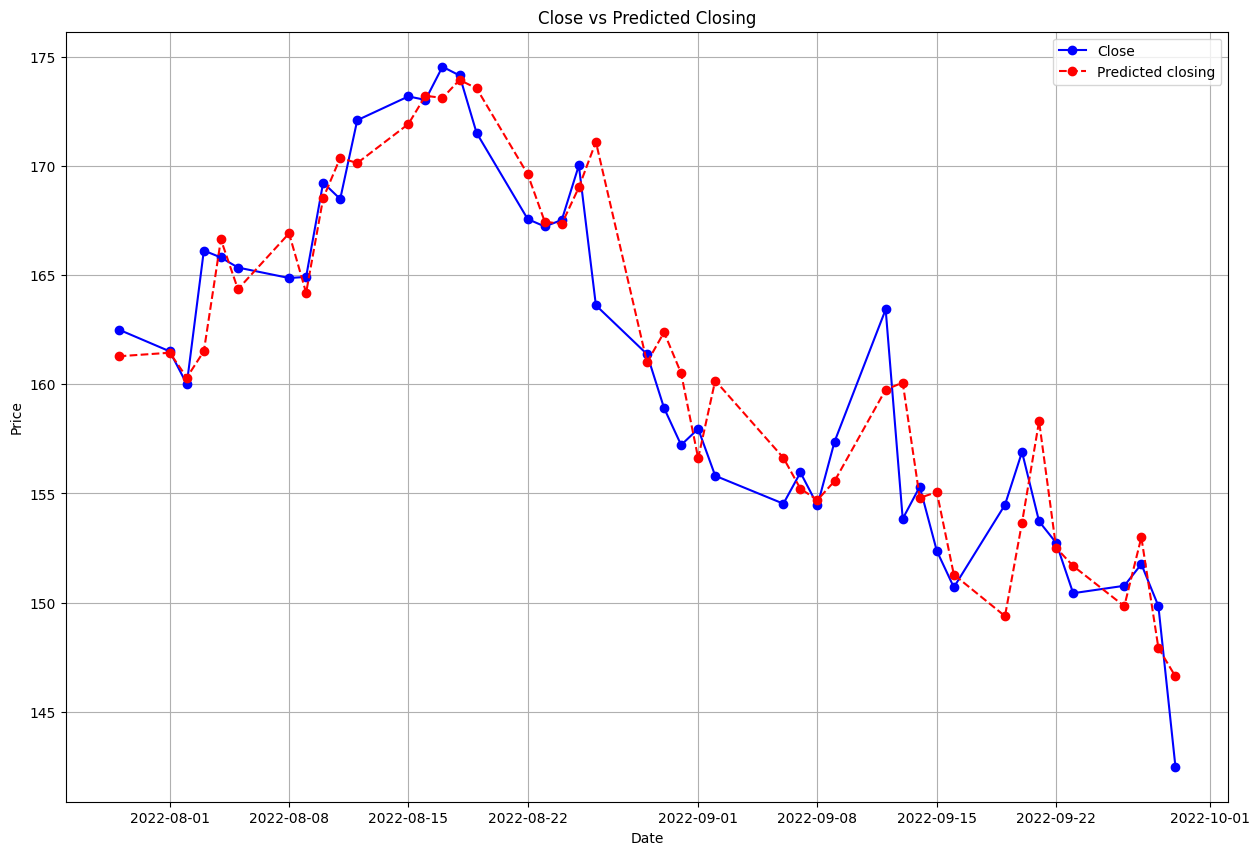

In [15]:
# Plot 'Close' vs 'Predicted closing'
plt.figure(figsize=(15, 10))
plt.plot(merged_df['Date'], merged_df['Close'], label='Close', marker='o', linestyle='-', color='b')
plt.plot(merged_df['Date'], merged_df['Predicted closing'], label='Predicted closing', marker='o', linestyle='--', color='r')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Close vs Predicted Closing')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Evaluation

In [17]:
mean_close = merged_df['Close'].mean()
mean_predicted = merged_df['Predicted closing'].mean()

numerator = ((merged_df['Close'] - mean_close) * (merged_df['Predicted closing'] - mean_predicted)).sum()
denominator = (((merged_df['Close'] - mean_close) ** 2).sum() * ((merged_df['Predicted closing'] - mean_predicted) ** 2).sum()) ** 0.5

correlation_coefficient = numerator / denominator

print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.9449516253631765


In [18]:
mape = (abs(merged_df['Close'] - merged_df['Predicted closing']) / merged_df['Close']).mean() * 100

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 1.22%
